### Кириленко Елена

In [ ]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
%matplotlib inline
import scipy
import math

import tqdm 
from tqdm import tqdm_notebook



Скачиваем данные из файла в 2 массива в зависимости от типа картинки

In [200]:
indoor = []
outdoor = []

for n in range(6708):
    try:
        image = scipy.misc.imread('data/train/indoor_' + str(n) + '.jpg')
        indoor.append(image)
    except:
        pass
    
for n in range(3157):
    try:
        image = scipy.misc.imread('data/train/outdoor_' + str(n) + '.jpg')
        outdoor.append(image)
    except:
        pass

indoor = np.array(indoor)
outdoor = np.array(outdoor)
print('Кол-во картинок indoor: ', len(indoor))
print('Кол-во картинок outdoor: ', len(outdoor))

Кол-во картинок indoor:  4702
Кол-во картинок outdoor:  2203


Считываем тестовые картинки

In [201]:
preliminary_test_images = []

for n in range(2960):
    try:
        image = scipy.misc.imread('data/test/img_' + str(n) + '.jpg')
        preliminary_test_images.append(image)
    except:
        pass

preliminary_test_images = np.array(preliminary_test_images)
print('Кол-во картинок test: ', len(preliminary_test_images))

Кол-во картинок test:  2960


Посмотрим на наши картинки (первые из классов indoor, outdoor и test)

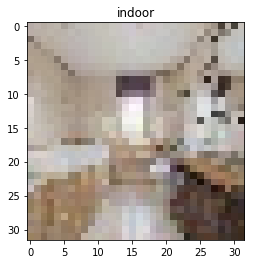

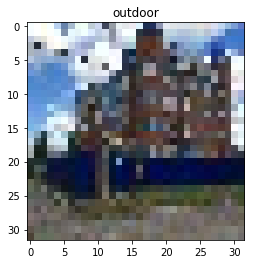

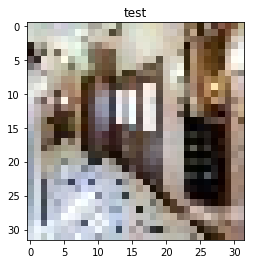

In [202]:
plt.imshow(indoor[0])
plt.title('indoor')
plt.show()
plt.imshow(outdoor[0])
plt.title('outdoor')
plt.show()
plt.imshow(preliminary_test_images[0])
plt.title('test')
plt.show()

### Балансировка классов

Видим, что размеры классов очень несбалансированы. Линейные модели, в частности логистическая регрессия, плохо работают на таких данных. Нужно сбалансировать размеры классов. Для этого сделаем клоны объектов меньшего класса (outdoor). Но для достижения более хороших результатов сделаем не просто клоны, а зеркальные клоны, то есть зеркально перевернем картинки (лево-право). Почему так можно? Заметим, что в данном случае зеркальное отображение не портит ответ, так как картинка и зеркально перевернутая картинка одинаково относятся либо к улице, либо к помещению. При этом такое клонирование даст нам новые данные, на которых мы сможем обучиться.

Добавляем зеркально отображенные картинки

In [203]:
outdoor_mapping = []
for image in outdoor:
    outdoor_mapping.append(image[:, ::-1, :])

In [204]:
outdoor = np.concatenate((outdoor, outdoor_mapping))
print('В классе outdoor стало: {} картинок '.format(outdoor.shape[0]))

В классе outdoor стало: 4406 картинок 


Для полной балансировки классов осталось добавить 296 картинок из класса outdoor. Добавим рандомные 296 картинок из уже имеющихся

In [205]:
np.random.seed(0)
random_indeces = np.random.choice(outdoor.shape[0], 296)
outdoor = np.concatenate((outdoor, outdoor[random_indeces]))
print('В классе outdoor стало: {} картинок '.format(outdoor.shape[0]))

В классе outdoor стало: 4702 картинок 


## Обработка данных

Создаем выборку и ответы к ней. Для удобства ответ для каждой картинки представим в виде пары чисел, где первое число отвечает за то принадлежит ли объект классу indoor, а второе за принадлежность классу outdoor. То есть если объект принадлежит indoor, то ответ будет (1, 0), если outdoor, то (0, 1)

In [206]:
preliminary_data = np.concatenate((indoor, outdoor))
temp = np.append(np.ones(indoor.shape[0]) , np.zeros(outdoor.shape[0])).reshape((1, preliminary_data.shape[0]))
labels = np.concatenate((temp, 1 - temp)).T
print('Размер выборки: ', preliminary_data.shape)
print('Размер ответов: ' , labels.shape)

Размер выборки:  (9404, 32, 32, 3)
Размер ответов:  (9404, 2)


### Решафл данных
Наши данные отсортированны по классам. Сначала идет класс indoor, потом outdoor. Нужно их зарешафлить.

In [207]:
np.random.seed(1)
indeces_shuffle = np.arange(preliminary_data.shape[0])
np.random.shuffle(indeces_shuffle)
preliminary_data = preliminary_data[indeces_shuffle].reshape(preliminary_data.shape)
labels = labels[indeces_shuffle].reshape(labels.shape)

## Добавление фичей
1) Заметим, что пиксели кроме нужной информации несут еще и мусорную информацию. Пример для понимания: если у нас есть трава и на ней лежит что-то маленькое красного цвета, то этот красный пиксель нам не даст никакой информации о том, что это картинка улицы. Даже наоборот, этот пиксель может испортить наше предсказание.<br>
Поэтому идея : не рассматривать все цвета, имеющиеся на картинке, а рассматривать кол-во цветов на картинке, попавшие в определенные промежутки цветов. То есть разделим все цвета на $k$ равных промежутков и посмотрим как наши исходные цвета распределились по ним. Для этого построим гистограмму распределения цветов. <br>
Сделаем то же самое  только не для всей картинки, а для подкартинок - прямоугольников размера $p*q$. Я разбивала картинку на 16 квадратов размера $8*8$ и на 64 квадрата размера $4*4$.<br> <br>
2) Для всей картинки посмотрим на среднее значение и на отклонение по каждому из каналов. <br> 
Для каждой подкартинки (квадрата размера $8*8$ и $4*4$) также посмотрим на среднее значение и на отклонение по каждому из каналов. <br> <br>
3) Для всей картинки по каждому из каналов (R G B) посмотрим на примерное максимальное и минимальное значение интенсивности этого канала. Здесь примерный означает среднее значение 10ти пикселей с максимальным значением интенсивности и 10ти с минимальным значением.  (Это сделает модель более устойчивой к выбросам)<br> То же самое сделаем для квадратов размера $8*8$ и $4*4$.<br> <br>
4) Построим гистограмму аналогичную пункту 1), только для каждого из каналов. Также сделаем для подкартинок размерами $4*4$ и $8*8$ <br> <br>
5) hog - гистограмма градиентов для изображения (база (псевдокод) взята из Стэнфордского курса CS231) <br>
Сначала нам нужно для каждого пикселя вычислить вектор градиента, что является просто мерой изменения значений пикселей вдоль направления x и y-направления вокруг каждого пикселя.  <br> 
Как считать вектор градиента? Для начала нужно перевести картинку в черно-белый. После для каждого пикселя мы рассматриваем пиксели слева и справа и сверху и снизу. Пусть для текущего пикселя значения пикселя справа - a, слева - b, снизу - c, сверху -  d. Вектор градиента для этого пикселя равен $(a-b, c-d)$. Тогда величина градиента равна $\sqrt{(a-b)^2 + (c-d)^2}$, а угол равен $arctg(\frac{c-d}{a-b})$ <br>

Внутри выбранной подкартинки (в нашем случае $8*8$ и $4*4$) мы вычисляем вектор градиента на каждом пикселе. <br>
После мы берем все эти векторы градиента и помещаем их в гистограмму с 9тью корзинками. Каждая корзинка - угол в 20 градусов (0-20, 20-40,..., 160-180).


Вспомогательные функции, которые возвращают для определенной фичи матрицу, где каждая строка является массивом этой фичи для определенного объекта из data.

In [245]:
def hist_hsv_full(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        to_hsv = matplotlib.colors.rgb_to_hsv(data[i] / 255)
        hist, bin_edges = np.histogram(to_hsv[:,:,0], range=(0, 1), bins=20, density=True)
        feature.append(list(hist))
    return np.array(feature)
    
def hist_hsv_8_8(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        feature_i = np.array([])
        for a in range(4):
            for b in range(4):
                to_hsv = matplotlib.colors.rgb_to_hsv(data[i][8*a : 8*(a+1), 8*b : 8*(b+1), :] / 255)
                hist, bin_edges = np.histogram(to_hsv[:,:,0], range=(0, 1), bins=20, density=True)
                feature_i = np.concatenate((feature_i, hist))
        feature.append(list(feature_i))
    return np.array(feature)


def hist_hsv_4_4(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        feature_i = np.array([])
        for a in range(8):
            for b in range(8):
                to_hsv = matplotlib.colors.rgb_to_hsv(data[i][4*a : 4*(a+1), 4*b : 4*(b+1), :] / 255)
                hist, bin_edges = np.histogram(to_hsv[:,:,0], range=(0, 1), bins=20, density=True)
                feature_i = np.concatenate((feature_i, hist))
        feature.append(list(feature_i))
    return np.array(feature)

def mean_std_channel_full(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        mean_red = data[i][:,:,0].mean() / 255
        mean_green = data[i][:,:,1].mean()  / 255
        mean_blue = data[i][:,:,2].mean()  / 255
        std_red = data[i][:,:,0].std() / 255
        std_green = data[i][:,:,1].std()  / 255
        std_blue = data[i][:,:,2].std()  / 255
        feature.append([mean_red, mean_green, mean_blue, std_red, std_green, std_blue,
                       np.sqrt(std_red), np.sqrt(std_green), np.sqrt(std_blue)])
    return np.array(feature)

def mean_std_channel_8_8(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        feature_i = np.array([])
        for a in range(4):
            for b in range(4):
                mean_red = data[i][8*a : 8*(a+1), 8*b : 8*(b+1), 0].mean()  / 255
                mean_green = data[i][8*a : 8*(a+1), 8*b : 8*(b+1) ,1].mean()  / 255
                mean_blue = data[i][8*a : 8*(a+1), 8*b : 8*(b+1) ,2].mean()  / 255
                std_red = data[i][8*a : 8*(a+1), 8*b : 8*(b+1), 0].std()  / 255
                std_green = data[i][8*a : 8*(a+1), 8*b : 8*(b+1) ,1].std()  / 255
                std_blue = data[i][8*a : 8*(a+1), 8*b : 8*(b+1) ,2].std()  / 255
                feature_i = np.concatenate((feature_i,[mean_red, mean_green, mean_blue, std_red, std_green, std_blue,
                                                      np.sqrt(std_red), np.sqrt(std_green), np.sqrt(std_blue)]))
        feature.append(list(feature_i))
    return np.array(feature)


def mean_std_channel_4_4(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        feature_i = np.array([])
        for a in range(8):
            for b in range(8):
                mean_red = data[i][4*a : 4*(a+1), 4*b : 4*(b+1), 0].mean()  / 255
                mean_green = data[i][4*a : 4*(a+1), 4*b : 4*(b+1) ,1].mean()  / 255
                mean_blue = data[i][4*a : 4*(a+1), 4*b : 4*(b+1) ,2].mean()  / 255
                std_red = data[i][4*a : 4*(a+1), 4*b : 4*(b+1), 0].std()  / 255
                std_green = data[i][4*a : 4*(a+1), 4*b : 4*(b+1) ,1].std()  / 255
                std_blue = data[i][4*a : 4*(a+1), 4*b : 4*(b+1) ,2].std()  / 255
                feature_i = np.concatenate((feature_i,[mean_red, mean_green, mean_blue, std_red, std_green, std_blue,
                                                      np.sqrt(std_red), np.sqrt(std_green), np.sqrt(std_blue)]))
        feature.append(list(feature_i))
    return np.array(feature)

def min_max_channel_full(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        sorted_red = np.sort(data[i][:,:,0].ravel())
        sorted_green = np.sort(data[i][:,:,1].ravel())
        sorted_blue = np.sort(data[i][:,:,2].ravel())
        max_red = sorted_red[-10:].mean()  / 255
        min_red = sorted_red[:10].mean()  / 255
        max_green = sorted_green[-10:].mean()  / 255
        min_green = sorted_green[:10].mean()  / 255
        max_blue = sorted_blue[-10:].mean()  / 255
        min_blue = sorted_blue[:10].mean()  / 255
        feature.append([max_red,min_red, max_green, min_green, max_blue, min_blue])
    return np.array(feature)

def min_max_channel_8_8(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        feature_i = np.array([])
        for a in range(4):
            for b in range(4):    
                sorted_red = np.sort(data[i][8*a : 8*(a+1), 8*b : 8*(b+1) ,0].ravel())
                sorted_green = np.sort(data[i][8*a : 8*(a+1), 8*b : 8*(b+1) ,1].ravel())
                sorted_blue = np.sort(data[i][8*a : 8*(a+1), 8*b : 8*(b+1) ,2].ravel())
                max_red = sorted_red[-8:].mean()  / 255
                min_red = sorted_red[:8].mean()  / 255
                max_green = sorted_green[-8:].mean()  / 255
                min_green = sorted_green[:8].mean()  / 255
                max_blue = sorted_blue[-8:].mean()  / 255
                min_blue = sorted_blue[:8].mean()  / 255
                feature_i = np.concatenate((feature_i, [max_red,min_red, max_green, min_green, max_blue, min_blue]))
        feature.append(list(feature_i))
    return np.array(feature)
                
def min_max_channel_4_4(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        feature_i = np.array([])
        for a in range(8):
            for b in range(8):    
                sorted_red = np.sort(data[i][4*a : 4*(a+1), 4*b : 4*(b+1) ,0].ravel())
                sorted_green = np.sort(data[i][4*a : 4*(a+1), 4*b : 4*(b+1) ,1].ravel())
                sorted_blue = np.sort(data[i][4*a : 4*(a+1), 4*b : 4*(b+1) ,2].ravel())
                max_red = sorted_red[-4:].mean()  / 255
                min_red = sorted_red[:4].mean()  / 255
                max_green = sorted_green[-4:].mean()  / 255
                min_green = sorted_green[:4].mean()  / 255
                max_blue = sorted_blue[-4:].mean()  / 255
                min_blue = sorted_blue[:4].mean()  / 255
                feature_i = np.concatenate((feature_i, [max_red,min_red, max_green, min_green, max_blue, min_blue]))
        feature.append(list(feature_i))  
    return np.array(feature)
                
                
def hist_channel_full(data):
    feature = []              
    for i in tqdm_notebook(range(len(data))):
        hist_red, bin_edges = np.histogram(data[i][:, :,0] / 255, range=(0, 1), bins=10, density=True)
        hist_green, bin_edges = np.histogram(data[i][:, :,1] / 255, range=(0, 1), bins=10, density=True)
        hist_blue, bin_edges = np.histogram(data[i][:, :,2] / 255, range=(0, 1), bins=10, density=True)
        feature.append(list(hist_red) + list(hist_green) + list(hist_blue))
    return np.array(feature)
                
                
def hist_channel_8_8(data):
    feature = []                
    for i in tqdm_notebook(range(len(data))):
        feature_i = np.array([])
        for a in range(4):
            for b in range(4):
                hist_red, bin_edges = np.histogram(data[i][8*a : 8*(a+1), 8*b : 8*(b+1),0] / 255, range=(0, 1), bins=10, density=True)
                hist_green, bin_edges = np.histogram(data[i][8*a : 8*(a+1), 8*b : 8*(b+1),1] / 255, range=(0, 1), bins=10, density=True)
                hist_blue, bin_edges = np.histogram(data[i][8*a : 8*(a+1), 8*b : 8*(b+1),2] / 255, range=(0, 1), bins=10, density=True)
                feature_i = np.concatenate((feature_i, list(hist_red) + list(hist_green) + list(hist_blue)))
        feature.append(list(feature_i))
    return np.array(feature)
                
                
def hist_channel_4_4(data):
    feature = []
    for i in tqdm_notebook(range(len(data))):
        feature_i = np.array([])
        for a in range(8):
            for b in range(8):
                hist_red, bin_edges = np.histogram(data[i][4*a : 4*(a+1), 4*b : 4*(b+1),0] / 255, range=(0, 1), bins=10, density=True)
                hist_green, bin_edges = np.histogram(data[i][4*a : 4*(a+1), 4*b : 4*(b+1),1] / 255, range=(0, 1), bins=10, density=True)
                hist_blue, bin_edges = np.histogram(data[i][4*a : 4*(a+1), 4*b : 4*(b+1),2] / 255, range=(0, 1), bins=10, density=True)
                feature_i = np.concatenate((feature_i, list(hist_red) + list(hist_green) + list(hist_blue)))
        feature.append(list(feature_i))
    return np.array(feature)
                
            
#гистограмма градиентов
#разделяем на квадраты 8*8 клеток
def hog_8_8(data):
    feature = []  
    for i in tqdm_notebook(range(len(data))):
        #конвертируем в черно-белый
        gray_image = np.dot(data[i][...,:3], [0.299, 0.587, 0.144])
        #кол-во корзинок
        orientations = 9

        #считаем градиенты по направлениям
        
        gx = np.zeros(gray_image.shape)
        gy = np.zeros(gray_image.shape)
        
        #по первому направлению 
        #считаем попарные разницы между соседними пикселями по горизонтальному направлению
        gx[:, :-1] = np.diff(gray_image, n=1, axis=1)
        #по второму направлению
        gy[:-1, :] = np.diff(gray_image, n=1, axis=0)
        
        # находим величину градиента и угол
        grad_value = np.sqrt(gx ** 2 + gy ** 2)
        grad_angle = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90
        
        orientation_hist = np.zeros((4, 4, orientations))
        for j in range(orientations):
            #находим градиенты, которые лежат в определенном углу в 20 градусов
            definite_angle = np.where(grad_angle < 180 / orientations * (j + 1), grad_angle, 0)
            definite_angle = np.where(grad_andle >= 180 / orientations * j, definite_angle, 0)
            #получаем массив из True и False в зависимости от принадлежности угла определенном углу в 20 градусов
            temp = definite_angle > 0
            #рассматриваем величины градиентов, попавших в этот угол
            definite_value = np.where(temp, grad_value, 0)
            orientation_hist[:,:,j] = uniform_filter(definite_value, size=(8, 8))[4::8, 4::8].T
        feature.append(list(orientation_hist.ravel()))
    return np.array(feature)

def hog_4_4(data):
    feature = []  
    for i in tqdm_notebook(range(len(data))):
        #конвертируем в черно-белый
        gray_image = np.dot(data[i][...,:3], [0.299, 0.587, 0.144])
        #кол-во корзинок
        orientations = 9

        #считаем градиенты по направлениям
        
        gx = np.zeros(gray_image.shape)
        gy = np.zeros(gray_image.shape)
        
        #по первому направлению 
        #считаем попарные разницы между соседними пикселями по горизонтальному направлению
        gx[:, :-1] = np.diff(gray_image, n=1, axis=1)
        #по второму направлению
        gy[:-1, :] = np.diff(gray_image, n=1, axis=0)
        
        # находим величину градиента и угол
        grad_value = np.sqrt(gx ** 2 + gy ** 2)
        grad_angle = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90
        
        orientation_hist = np.zeros((8, 8, orientations))
        for j in range(orientations):
            #находим градиенты, которые лежат в определенном углу в 20 градусов
            definite_angle = np.where(grad_angle < 180 / orientations * (j + 1), grad_angle, 0)
            definite_angle = np.where(grad_andle >= 180 / orientations * j, definite_angle, 0)
            #получаем массив из True и False в зависимости от принадлежности угла определенном углу в 20 градусов
            temp = definite_angle > 0
            #рассматриваем величины градиентов, попавших в этот угол
            definite_value = np.where(temp, grad_value, 0)
            orientation_hist[:,:,j] = uniform_filter(definite_value, size=(4, 4))[2::4, 2::4].T
        feature.append(list(orientation_hist.ravel()))
    return np.array(feature)


Функция, возвращающая 2 словаря: словарь из фичей для наших данных и такой же словарь для тестовых данных. Ключи - названия фичей, значения - матрицы , составленные из фичей, где строка матрицы отвечает одному объекту из 

In [209]:
def dict_features(data, test_data):
    features_train = dict()
    features_test = dict()
    
    #1
    features_train['hist_hsv_full'] = hist_hsv_full(data)
    features_test['hist_hsv_full'] = hist_hsv_full(test_data)
    
    features_train['hist_hsv_8_8'] = hist_hsv_8_8(data)
    features_test['hist_hsv_8_8'] = hist_hsv_8_8(test_data)
           
    features_train['hist_hsv_4_4'] = hist_hsv_4_4(data)
    features_test['hist_hsv_4_4'] = hist_hsv_4_4(test_data)
    
    #2
    features_train['mean_std_channel_full'] = mean_std_channel_full(data)
    features_test['mean_std_channel_full'] = mean_std_channel_full(test_data)
    
    features_train['mean_std_channel_8_8'] = mean_std_channel_8_8(data)
    features_test['mean_std_channel_8_8'] = mean_std_channel_8_8(test_data)
        
    features_train['mean_std_channel_4_4'] = mean_std_channel_4_4(data)
    features_test['mean_std_channel_4_4'] = mean_std_channel_4_4(test_data)
    
    #3
    features_train['min_max_channel_full'] = min_max_channel_full(data)
    features_test['min_max_channel_full'] = min_max_channel_full(test_data)

    features_train['min_max_channel_8_8'] = min_max_channel_8_8(data)
    features_test['min_max_channel_8_8'] = min_max_channel_8_8(test_data)

    features_train['min_max_channel_4_4'] = min_max_channel_4_4(data)
    features_test['min_max_channel_4_4'] = min_max_channel_4_4(test_data)
    
    #4 распределение по отдельным каналам
    features_train['hist_channel_full'] = hist_channel_full(data)
    features_test['hist_channel_full'] = hist_channel_full(test_data)

    features_train['hist_channel_8_8'] = hist_channel_8_8(data)
    features_test['hist_channel_8_8'] = hist_channel_8_8(test_data)

    features_train['hist_channel_4_4'] = hist_channel_4_4(data)
    features_test['hist_channel_4_4'] = hist_channel_4_4(test_data)
    
    #5
    features_train['hog_8_8'] = hog_8_8(data)
    features_test['hog_8_8'] = hog_8_8(test_data)
    
    features_train['hog_4_4'] = hog_4_4(data)
    features_test['hog_4_4'] = hog_4_4(test_data)

    return features_train, features_test


**работает минут 15** 

In [210]:
_save_features, _save_features_test = dict_features(preliminary_data, preliminary_test_images)

In [211]:
dict_data, dict_test_images = _save_features.copy(), _save_features_test.copy()

## Теория для выполнения.  <br>
Пусть W - матрица весов размера D * C, где D - размер вектора, представляющего картинку, C - кол-во классов, то есть C = 2 <br>
Матрица X - матрица размера N * D, где где N - кол-во картинок. <br>
y - вектор ответов. <br><br>
В данном случае минимизируемая функция это кросс-энтропия (log-loss). В нашем случае для $x_i$ она равна $$L_{x_i} = -\sum_{j=1}^{j=2} y^{j}_{true, i} * log(y^{j}_{pred, i}) $$ , <br>
где $y_{true, i}$ - вектор истинных ответов для i-ой картинки ($x_i$), то есть вектор длины 2 с одной 1 и остальными 0. <br>
$y_{pred, i}$ - вектор предсказанных вероятностей для i-ой картинки ($x_i$), то есть вектор длины 2 состоящий из вероятностей принадлежности i-ой картинки к классам. <br>
Заметим, что элементы вектора $y_{true, i}$ - нули во всех местах, кроме истинного класса, а на месте истинного класса стоит 1. Пусть номер истинного класса - $k$ <br>
Тогда $$L_{x_i} = -\sum_{j=1}^{j=2} y^{j}_{true, i} * log(y^{j}_{pred, i}) = - y^{k}_{true, i} * log(y^{k}_{pred, i}) = -log(y^{k}_{pred, i})$$ <br> 
Таким образом, если картинка $x_i$ принадлежит классу $k$, то $L_{x_i} = -log(y^{k}_{pred, i})$ <br>
При этом, чтобы получить именно вероятности, а не большие числа, нам предлагают использовать $softmax(x) = \frac{e^x}{\sum(e^x)}$ <br>
Поэтому вместо $y^{j}_{pred, i}$ в кросс-энтропию мы подставляем $softmax(y^{j}_{pred, i})$ (для приведения к вероятностям) <br>
Тогда получим : $$L_{x_i} = -log(softmax(y^{k}_{pred, i})) = -log(\frac{e^{y^{k}_{pred, i}}}{\sum_{j=1}^{2} e^{y^{j}_{pred, i}}}) = - y^{k}_{pred, i} + log(\sum_{j=1}^{2} e^{y^{j}_{pred, i}})$$ <br>
<br>
Итоговая кросс-энтропия - среднее значение для всех объектов: $L = \frac{1}{N} \sum_{i=1}^{N} L_{x_i}$ <br>
Минимизировать кросс-энтропию будем градиентным спуском. Для этого нам понадобится уметь находить градиент функции $L$ <br>
Сначала поймем, что $y^{j}_{pred, i} = <w_j x_i>$ <br>
Тогда $$L_{x_i} = -<w_k x_i> + log(\sum_{j=1}^{2} e^{<w_j x_i>})$$ <br>
(напоминание $k$ - номер истинного класса картинки $x_i$) <br>
Продифференцируем: 
$$\frac{d L_{x_i}}{d w_k} = -x_i + \frac{e^{<w_k x_i>}}{\sum_{j=1}^{2} e^{<w_j x_i>}} x_i = (-1 + \frac{e^{<w_k x_i>}}{\sum_{j=1}^{2} e^{<w_j x_i>}}) x_i = (-1 + \frac{e^{y^{k}_{pred, i}}}{\sum_{j=1}^{2} e^{y^{j}_{pred, i}}}) x_i = (-1 + softmax(y^{k}_{pred, i})) \; x_i$$

$$\frac{d L_{x_i}}{d w_s} = \frac{e^{<w_s x_i>}}{\sum_{j=1}^{2} e^{<w_j x_i>}} x_i = \frac{e^{y^{s}_{pred, i}}}{\sum_{j=1}^{2} e^{y^{j}_{pred, i}}} x_i = softmax(y^{s}_{pred, i})\; x_i\;\;\;\; \;\;\; s \ne k$$ <br>

Заметим, что вычитаем 1 только в тех местах, где в матрице $y_{true}$ стоит 1. <br>
В силу того, что в матрице $y_{true}$ в остальных местах стоят нули, получим  $$\frac{d L}{d W} = \frac{1}{N}(softmax(y_{pred}) - y_{true}) X$$ <br>
<br>
Можно, конечно, было считать градиент численно по формуле $\frac{f(x + dx) - f(x)}{dx}$ взяв маленький $dx$, но это даст бОльшую погрешность, чем аналитический способ. 
<br> <br>
Также заметим, что все вышеописанное было только в терминах $X$  и $W$. Для того, чтобы не считать градиент по $b$ сделаем следующее: <br> Добавим к матрице $W$ в конец строчку из b_i (сначала это нули, потом модель подберет нужные числа), то есть теперь матрица имеет размер (D+1) * C, а к матрице $X$ добавим в конец столбец из единиц, то есть теперь матрица имеет размер N * (D+1). <br>
Тогда при умножении $X W$ мы как раз получим аналог вектора $b$.

### Регуляризация <br>
Теперь для того, чтобы избежать переобучения, будем штрафовать модель за большие веса (большие веса один из признаков переобучения). <br> 
###### L2-регулизация
Для этого к минимизируемой функции $L$ добавим $L_2$-регуляризацию. То есть теперь минимизируем функцию: $$L = \frac{1}{N} \sum_{i=1}^{N} L_{x_i} + \sum_{j=1}^{C} \sum_{k=1}^{D+1}{w_{j, k}}^2 = \frac{1}{N} \sum_{i=1}^{N} L_{x_i} + \lambda ||W||^2$$ <br>
(Напоминание, $C$ - кол-во классов, $D+1$ - кол-во признаков, включая единичный признак для имитирования вектора свободных коэффициентов), $\lambda$ - коэффициент регуляризации <br> <br>

Теперь нужно научиться находить градиент новой функции $L$. <br>
$$\frac{d ||W||^2}{dw_{i, j}} = \frac{d(\sum_{j=1}^{C} \sum_{k=1}^{D+1}{w_{j, k}}^2)}{d w_{i, j}} = 2 w_{i, j}$$ <br>
$$\Rightarrow \frac{d ||W||^2}{dW} = 2  W$$ <br>
$$\Rightarrow \frac{dL}{dW} = \frac{1}{N}(softmax(y_{pred}) - y_{true}) X + 2\lambda W $$

###### L1-регулизация
Минимизируем функцию: $$L = \frac{1}{N} \sum_{i=1}^{N} L_{x_i} + \sum_{j=1}^{C} \sum_{k=1}^{D+1}{|w_{j, k}|}$$ <br>
Ищем градиент
$$\frac{d(\sum_{j=1}^{C} \sum_{k=1}^{D+1}{|w_{j, k}}|)}{d w_{i, j}} = sign(w_{i, j})$$ <br>
$$\Rightarrow \frac{d (\sum_{j=1}^{C} \sum_{k=1}^{D+1}{|w_{j, k}}|)}{dW} = sign(W)$$ <br>
$$\Rightarrow \frac{dL}{dW} = \frac{1}{N}(softmax(y_{pred}) - y_{true}) X + \lambda sign(W) $$

### Реализация

Функции softmax, кросс-энтропия и поиск градиента (градиент ищем аналитически в зависимости от типа регуляризации)

In [212]:
def softmax(y_pred):
    temp = np.exp(y_pred)
    return (temp / np.sum(temp, axis=1).reshape((temp.shape[0], 1)))

def log_loss(W, X, y, penalty='l1', lambd=0.01):
    y_pred = X.dot(W)
    L = (- y_pred[y==1] + np.log(np.sum(np.e ** (y_pred), axis=1))).mean()
    if penalty == 'l2':
        return L + lambd * np.linalg.norm(W)
    elif penalty == 'l1':
        return L + lambd * np.sum(np.abs(W))

def gradient(W, X, y, penalty='l1', lambd=0.01):
    grad = (X.T).dot(softmax(X.dot(W)) - y) / (X.shape[0])
    if penalty=='l2':
        return grad + lambd * 2*W
    elif penalty =='l1':
        return grad + lambd * np.sign(W)


Градиентный спуск. Шаг будем выбирать по методу Adam. <br>
Также на каждой итерации градиент будем вычислять не по всей выборке, а на ее случайной части.

In [213]:
def gradientDescentAdam(W, X_train, y_train, n_iter, X_test=None, y_test=None, eta=0.0001, beta1=0.9, beta2=0.999, \
                        eps=1e-8, penalty='l1', lambd = 1e-4, batch_size=400, trade=False):
    
    losses_train = []
    losses_test = []
    m = np.zeros((W.shape))
    v = np.zeros((W.shape))
    for i in (range(n_iter)):
        
        np.random.seed(i+3)
        indeces = np.random.choice(X_train.shape[0], batch_size)
    
        X_batch = X_train[indeces]
        y_batch = y_train[indeces]
        
        grad = gradient(W, X_batch, y_batch, penalty=penalty, lambd=lambd)
        
        m = beta1*m + (1-beta1) * grad
        v = beta2*v + (1-beta2) * (grad**2)
        W = W - eta * m / (np.sqrt(v) + eps)
        
        if(trade):
            losses_train.append(log_loss(W, X_train, y_train, penalty=penalty, lambd=lambd))
            losses_test.append(log_loss(W, X_test, y_test, penalty=penalty, lambd=lambd))

    if(trade):
        return W, losses_train, losses_test
    
    return W

Вспомогательные функции для подсчета результата.<br>

In [214]:
#функция, результат (0 или 1) для каждого объекта из X
def predict(W, X):
    y_pred = softmax(X.dot(W))
    return np.argmax(y_pred, axis=1)

#функция, возвращающая долю правильных ответов на выборке X
def accuracy(W, X, y):
    return (predict(W, X) == np.argmax(y, axis=1)).mean()

#функция, возвращающая rmse по выборке, ответам и весам
def rmse(W, X, y):
    y_pred = softmax(X.dot(W))
    return np.sqrt(np.mean((y - y_pred) ** 2))

### Подбор фичей
Все готово. Осталось только подобрать нужные фичи. Это нужно, так как некоторые фичи могут нести в себе ненужную информацию и только портить предсказание.

Напишем функцию, которая по названию фичей (словарю, где ключи - названия, а значения - true или false) добавляет нужные фичи для всех данных <br>
Первая функция возвращет массив для данных, которые размечены. <br>
Вторая - аналогичная функция для неразмеченных данных.

In [215]:
#features словарь, ключи - названия фичей, значения true или false (добавляем или не добавляем)
def add_features_data(features):
    result = dict_data['mean_std_channel_full']
    result = np.hstack((result, dict_data['min_max_channel_full']))
    result = np.hstack((result, dict_data['hog_8_8']))
    result = np.hstack((result, dict_data['hog_4_4']))
    if features['hist_hsv_full']:
        result = np.hstack((result, dict_data['hist_hsv_full']))
    if features['hist_hsv_8_8']:
        result = np.hstack((result, dict_data['hist_hsv_8_8']))
    if features['hist_hsv_4_4']:
        result = np.hstack((result, dict_data['hist_hsv_4_4']))
    if features['mean_std_channel_8_8']:
        result = np.hstack((result, dict_data['mean_std_channel_8_8']))
    if features['mean_std_channel_4_4']:
        result = np.hstack((result, dict_data['mean_std_channel_4_4']))
    if features['min_max_channel_8_8']:
        result = np.hstack((result, dict_data['min_max_channel_8_8']))
    if features['min_max_channel_4_4']:
        result = np.hstack((result, dict_data['min_max_channel_4_4']))
    if features['hist_channel_full']:
        result = np.hstack((result, dict_data['hist_channel_full']))
    if features['hist_channel_8_8']:
        result = np.hstack((result, dict_data['hist_channel_8_8']))
    if features['hist_channel_4_4']:
        result = np.hstack((result, dict_data['hist_channel_4_4']))
    return result.copy()
       
    
def add_features_test(features):
    result = dict_test_images['mean_std_channel_full']
    result = np.hstack((result, dict_test_images['min_max_channel_full']))
    result = np.hstack((result, dict_test_images['hog_8_8']))
    result = np.hstack((result, dict_test_images['hog_4_4']))
    if features['hist_hsv_full']:
        result = np.hstack((result, dict_test_images['hist_hsv_full']))
    if features['hist_hsv_8_8']:
        result = np.hstack((result, dict_test_images['hist_hsv_8_8']))
    if features['hist_hsv_4_4']:
        result = np.hstack((result, dict_test_images['hist_hsv_4_4']))
    if features['mean_std_channel_8_8']:
        result = np.hstack((result, dict_test_images['mean_std_channel_8_8']))
    if features['mean_std_channel_4_4']:
        result = np.hstack((result, dict_test_images['mean_std_channel_4_4']))
    if features['min_max_channel_8_8']:
        result = np.hstack((result, dict_test_images['min_max_channel_8_8']))
    if features['min_max_channel_4_4']:
        result = np.hstack((result, dict_test_images['min_max_channel_4_4']))
    if features['hist_channel_full']:
        result = np.hstack((result, dict_test_images['hist_channel_full']))
    if features['hist_channel_8_8']:
        result = np.hstack((result, dict_test_images['hist_channel_8_8']))
    if features['hist_channel_4_4']:
        result = np.hstack((result, dict_test_images['hist_channel_4_4']))
    return result.copy()

Теперь напишем функцию, которая будет принимать обучающую выборку и тестовую выборку, масштабировать обе, обучаться и после возвращать rmse на тестовой и на обучающей выборках. <br> <br>
Масштабировать нужно так как полученные признаки могут иметь разные порядки, а линейные модели с использованием регуляризации с таким плохо работают, так как при признаках разного порядка могут быть и оптимальные веса разного порядка, но большие веса мы запрещаем регуляризацией. <br>
Также сначала нужно инициализировать матрицу W. Инициализируем ее маленькими случайными значениями.<br>
Для имитации вектора свободных коэффициентов b добавляем к матрицам W и X по дополнительному вектору. (см ранее)

In [216]:
def normalize_fit_rmse(train_data, train_labels, test_data, test_labels):
    #масштабируем 
    mean = np.mean(train_data)
    std = np.std(train_data)
    train_data_scaled = (train_data - mean) / std
    test_data_scaled = (test_data - mean) / std
    
    #размеры матриц
    D = train_data_scaled.shape[1]
    N = train_data_scaled.shape[0]
    C = 2
    
    np.random.seed(10)
    #инициализируем матрицу весов
    W = np.random.randn(D, C) * 0.01
    
    #для имитации вектора b добавляем к матрицам W и X (train_data_scaled) по дополнительному вектору
    W = np.concatenate((W, np.zeros((1, C))))
    train_data_scaled = np.concatenate((train_data_scaled, np.ones((N, 1))), axis=1)
    test_data_scaled = np.concatenate((test_data_scaled, np.ones((test_data.shape[0], 1))), axis=1)
    
    #обучение
    n_iter = 900
    W_res = gradientDescentAdam(W.copy(), train_data_scaled, train_labels, n_iter, penalty='l1')
    
    
    rmse_test = rmse(W_res, test_data_scaled, test_labels)
    rmse_train = rmse(W_res, train_data_scaled, train_labels)
    return rmse_test, rmse_train

Делаем перебор по фичам. Для каждого набора выводим rmse для обучающей выборке и для валидационной

**работает долго (часа 3)**

In [247]:
rmses = []
for do_hist_hsv_full in [True, False]:
    for do_hist_hsv_4_4 in [True, False]:
        for do_hist_hsv_8_8 in [True, False]:
            for do_mean_std_channel_8_8 in [True, False]:
                for do_mean_std_channel_4_4 in [True, False]:
                    for do_min_max_channel_8_8 in [True, False]:
                        for do_min_max_channel_4_4 in [True, False]:
                            for do_hist_channel_full in [True, False]:
                                for do_hist_channel_8_8 in [True, False]:
                                    for do_hist_channel_4_4 in [True, False]:
                                        #добавляем фичи
                                        features = {'hist_hsv_full': do_hist_hsv_full, 
                                                    'hist_hsv_4_4': do_hist_hsv_4_4, 
                                                   'hist_hsv_8_8': do_hist_hsv_8_8, 
                                                    'mean_std_channel_8_8': do_mean_std_channel_8_8,
                                                   'mean_std_channel_4_4': do_mean_std_channel_4_4, 
                                                    'min_max_channel_8_8':do_min_max_channel_8_8,
                                                   'min_max_channel_4_4': do_min_max_channel_4_4, 
                                                    'hist_channel_full': do_hist_channel_full,
                                                    'hist_channel_8_8': do_hist_channel_8_8,
                                                    'hist_channel_4_4': do_hist_channel_4_4
                                                   }
                                        
                                        new_data = add_features_data(features)
                                        
                                        #разбиваем на обучающую и тестовую(валидационную) выборку
                                        train_data = new_data[:8000]
                                        train_labels = labels[:8000]
                                        test_data = new_data[8000:]
                                        test_labels = labels[8000:]
                                        rmse_test, rmse_train = normalize_fit_rmse(train_data, train_labels, 
                                                                                   test_data, test_labels)
                                        
                                        result = [do_hist_hsv_full, do_hist_hsv_4_4, do_hist_hsv_8_8, 
                                                  do_mean_std_channel_8_8, do_mean_std_channel_4_4, do_min_max_channel_8_8, 
                                                  do_min_max_channel_4_4, do_hist_channel_full, do_hist_channel_8_8,
                                                  do_hist_channel_4_4, rmse_test, rmse_train]
                                        rmses.append(result)
                                        print(do_hist_hsv_full, do_hist_hsv_4_4, do_hist_hsv_8_8,do_mean_std_channel_8_8,
                                                  do_mean_std_channel_4_4, do_min_max_channel_8_8, 
                                                  do_min_max_channel_4_4, do_hist_channel_full, do_hist_channel_8_8,
                                                  do_hist_channel_4_4, '\n Test: ', round(rmse_test, 6),
                                              '    Train: ', round(rmse_train, 6), '\n=======================')

True True True True True True True True True True 
 Test:  0.226127     Train:  0.095447 
True True True True True True True True True False 
 Test:  0.225366     Train:  0.13487 
True True True True True True True True False True 
 Test:  0.226075     Train:  0.098468 
True True True True True True True True False False 
 Test:  0.237423     Train:  0.154752 
True True True True True True True False True True 
 Test:  0.224641     Train:  0.095672 
True True True True True True True False True False 
 Test:  0.224996     Train:  0.134911 
True True True True True True True False False True 
 Test:  0.224715     Train:  0.098718 
True True True True True True True False False False 
 Test:  0.240895     Train:  0.158722 
True True True True True True False True True True 
 Test:  0.226194     Train:  0.09909 
True True True True True True False True True False 
 Test:  0.225401     Train:  0.137273 
True True True True True True False True False True 
 Test:  0.224443     Train:  0.101

True True True False True True True False False False 
 Test:  0.240835     Train:  0.159787 
True True True False True True False True True True 
 Test:  0.224604     Train:  0.097993 
True True True False True True False True True False 
 Test:  0.226027     Train:  0.138198 
True True True False True True False True False True 
 Test:  0.224112     Train:  0.102367 
True True True False True True False True False False 
 Test:  0.239031     Train:  0.160176 
True True True False True True False False True True 
 Test:  0.226095     Train:  0.098512 
True True True False True True False False True False 
 Test:  0.226318     Train:  0.138244 
True True True False True True False False False True 
 Test:  0.223181     Train:  0.102363 
True True True False True True False False False False 
 Test:  0.242198     Train:  0.164875 
True True True False True False True True True True 
 Test:  0.225496     Train:  0.097271 
True True True False True False True True True False 
 Test:  0.22

True True False True True True False False True False 
 Test:  0.226128     Train:  0.137709 
True True False True True True False False False True 
 Test:  0.224369     Train:  0.101957 
True True False True True True False False False False 
 Test:  0.242333     Train:  0.164086 
True True False True True False True True True True 
 Test:  0.225827     Train:  0.097113 
True True False True True False True True True False 
 Test:  0.22642     Train:  0.135095 
True True False True True False True True False True 
 Test:  0.224905     Train:  0.10044 
True True False True True False True True False False 
 Test:  0.238164     Train:  0.156322 
True True False True True False True False True True 
 Test:  0.225461     Train:  0.097345 
True True False True True False True False True False 
 Test:  0.226095     Train:  0.135655 
True True False True True False True False False True 
 Test:  0.225594     Train:  0.100507 
True True False True True False True False False False 
 Test:  0.

True True False False True False True True False False 
 Test:  0.238114     Train:  0.157372 
True True False False True False True False True True 
 Test:  0.224855     Train:  0.097307 
True True False False True False True False True False 
 Test:  0.225797     Train:  0.136896 
True True False False True False True False False True 
 Test:  0.223937     Train:  0.099986 
True True False False True False True False False False 
 Test:  0.241595     Train:  0.161527 
True True False False True False False True True True 
 Test:  0.224694     Train:  0.100187 
True True False False True False False True True False 
 Test:  0.225912     Train:  0.139436 
True True False False True False False True False True 
 Test:  0.224724     Train:  0.102694 
True True False False True False False True False False 
 Test:  0.239829     Train:  0.162218 
True True False False True False False False True True 
 Test:  0.224576     Train:  0.099803 
True True False False True False False False True 

True False True True True False False True True False 
 Test:  0.221537     Train:  0.164855 
True False True True True False False True False True 
 Test:  0.222652     Train:  0.126364 
True False True True True False False True False False 
 Test:  0.236589     Train:  0.188247 
True False True True True False False False True True 
 Test:  0.225223     Train:  0.122333 
True False True True True False False False True False 
 Test:  0.221189     Train:  0.165171 
True False True True True False False False False True 
 Test:  0.223731     Train:  0.126405 
True False True True True False False False False False 
 Test:  0.239122     Train:  0.193537 
True False True True False True True True True True 
 Test:  0.223975     Train:  0.121833 
True False True True False True True True True False 
 Test:  0.220685     Train:  0.164153 
True False True True False True True True False True 
 Test:  0.223961     Train:  0.124723 
True False True True False True True True False False 
 Tes

True False True False True False False False False False 
 Test:  0.239811     Train:  0.195365 
True False True False False True True True True True 
 Test:  0.225219     Train:  0.122287 
True False True False False True True True True False 
 Test:  0.220234     Train:  0.164753 
True False True False False True True True False True 
 Test:  0.223541     Train:  0.125652 
True False True False False True True True False False 
 Test:  0.234426     Train:  0.187899 
True False True False False True True False True True 
 Test:  0.225268     Train:  0.122006 
True False True False False True True False True False 
 Test:  0.220492     Train:  0.165125 
True False True False False True True False False True 
 Test:  0.223406     Train:  0.125464 
True False True False False True True False False False 
 Test:  0.236569     Train:  0.193479 
True False True False False True False True True True 
 Test:  0.224432     Train:  0.125673 
True False True False False True False True True Fals

True False False True False True True False True True 
 Test:  0.226863     Train:  0.137728 
True False False True False True True False True False 
 Test:  0.232311     Train:  0.185695 
True False False True False True True False False True 
 Test:  0.227521     Train:  0.143144 
True False False True False True True False False False 
 Test:  0.262527     Train:  0.225365 
True False False True False True False True True True 
 Test:  0.229331     Train:  0.140977 
True False False True False True False True True False 
 Test:  0.236021     Train:  0.190479 
True False False True False True False True False True 
 Test:  0.229141     Train:  0.145506 
True False False True False True False True False False 
 Test:  0.273843     Train:  0.236552 
True False False True False True False False True True 
 Test:  0.229161     Train:  0.141509 
True False False True False True False False True False 
 Test:  0.235606     Train:  0.190974 
True False False True False True False False Fals

True False False False False True False True True False 
 Test:  0.234715     Train:  0.191749 
True False False False False True False True False True 
 Test:  0.228048     Train:  0.147566 
True False False False False True False True False False 
 Test:  0.278272     Train:  0.242198 
True False False False False True False False True True 
 Test:  0.228606     Train:  0.143733 
True False False False False True False False True False 
 Test:  0.235176     Train:  0.192886 
True False False False False True False False False True 
 Test:  0.229579     Train:  0.147768 
True False False False False True False False False False 
 Test:  0.284936     Train:  0.253179 
True False False False False False True True True True 
 Test:  0.227836     Train:  0.139792 
True False False False False False True True True False 
 Test:  0.233369     Train:  0.187638 
True False False False False False True True False True 
 Test:  0.229019     Train:  0.144176 
True False False False False False T

False True True True False True False False False False 
 Test:  0.243576     Train:  0.169852 
False True True True False False True True True True 
 Test:  0.22692     Train:  0.099302 
False True True True False False True True True False 
 Test:  0.226189     Train:  0.139123 
False True True True False False True True False True 
 Test:  0.225156     Train:  0.102972 
False True True True False False True True False False 
 Test:  0.239058     Train:  0.160558 
False True True True False False True False True True 
 Test:  0.226543     Train:  0.098875 
False True True True False False True False True False 
 Test:  0.226429     Train:  0.139642 
False True True True False False True False False True 
 Test:  0.225598     Train:  0.103056 
False True True True False False True False False False 
 Test:  0.24221     Train:  0.165645 
False True True True False False False True True True 
 Test:  0.226351     Train:  0.103304 
False True True True False False False True True False 


False True True False False False True False True False 
 Test:  0.22707     Train:  0.140673 
False True True False False False True False False True 
 Test:  0.226282     Train:  0.104833 
False True True False False False True False False False 
 Test:  0.24209     Train:  0.166883 
False True True False False False False True True True 
 Test:  0.225752     Train:  0.10254 
False True True False False False False True True False 
 Test:  0.227789     Train:  0.143643 
False True True False False False False True False True 
 Test:  0.225994     Train:  0.106951 
False True True False False False False True False False 
 Test:  0.241443     Train:  0.167042 
False True True False False False False False True True 
 Test:  0.225672     Train:  0.102733 
False True True False False False False False True False 
 Test:  0.22732     Train:  0.143604 
False True True False False False False False False True 
 Test:  0.225735     Train:  0.106837 
False True True False False False False F

False True False True False False False True False True 
 Test:  0.225261     Train:  0.106414 
False True False True False False False True False False 
 Test:  0.24084     Train:  0.166726 
False True False True False False False False True True 
 Test:  0.225312     Train:  0.102943 
False True False True False False False False True False 
 Test:  0.227501     Train:  0.143445 
False True False True False False False False False True 
 Test:  0.225587     Train:  0.106208 
False True False True False False False False False False 
 Test:  0.243951     Train:  0.172894 
False True False False True True True True True True 
 Test:  0.225478     Train:  0.096932 
False True False False True True True True True False 
 Test:  0.226711     Train:  0.135919 
False True False False True True True True False True 
 Test:  0.2249     Train:  0.100867 
False True False False True True True True False False 
 Test:  0.238549     Train:  0.156319 
False True False False True True True False Tr

False True False False False False False False False False 
 Test:  0.244023     Train:  0.174825 
False False True True True True True True True True 
 Test:  0.227297     Train:  0.117648 
False False True True True True True True True False 
 Test:  0.220551     Train:  0.160365 
False False True True True True True True False True 
 Test:  0.225844     Train:  0.120647 
False False True True True True True True False False 
 Test:  0.232329     Train:  0.181189 
False False True True True True True False True True 
 Test:  0.225304     Train:  0.118096 
False False True True True True True False True False 
 Test:  0.220028     Train:  0.160831 
False False True True True True True False False True 
 Test:  0.225178     Train:  0.121178 
False False True True True True True False False False 
 Test:  0.234799     Train:  0.18512 
False False True True True True False True True True 
 Test:  0.225837     Train:  0.121154 
False False True True True True False True True False 
 Test:

False False True False True True True False True True 
 Test:  0.226008     Train:  0.118769 
False False True False True True True False True False 
 Test:  0.220859     Train:  0.161831 
False False True False True True True False False True 
 Test:  0.2254     Train:  0.122285 
False False True False True True True False False False 
 Test:  0.235154     Train:  0.186407 
False False True False True True False True True True 
 Test:  0.225819     Train:  0.120573 
False False True False True True False True True False 
 Test:  0.221568     Train:  0.164285 
False False True False True True False True False True 
 Test:  0.225399     Train:  0.124829 
False False True False True True False True False False 
 Test:  0.236554     Train:  0.187769 
False False True False True True False False True True 
 Test:  0.225663     Train:  0.121544 
False False True False True True False False True False 
 Test:  0.221483     Train:  0.164722 
False False True False True True False False False 

False False False True True True False True True False 
 Test:  0.237151     Train:  0.190869 
False False False True True True False True False True 
 Test:  0.232745     Train:  0.146462 
False False False True True True False True False False 
 Test:  0.280687     Train:  0.241118 
False False False True True True False False True True 
 Test:  0.229943     Train:  0.14272 
False False False True True True False False True False 
 Test:  0.237516     Train:  0.191684 
False False False True True True False False False True 
 Test:  0.231109     Train:  0.147232 
False False False True True True False False False False 
 Test:  0.28941     Train:  0.255016 
False False False True True False True True True True 
 Test:  0.23285     Train:  0.141142 
False False False True True False True True True False 
 Test:  0.236112     Train:  0.188435 
False False False True True False True True False True 
 Test:  0.231132     Train:  0.144727 
False False False True True False True True False

False False False False True True False False False True 
 Test:  0.230367     Train:  0.14844 
False False False False True True False False False False 
 Test:  0.296203     Train:  0.263183 
False False False False True False True True True True 
 Test:  0.231902     Train:  0.141567 
False False False False True False True True True False 
 Test:  0.237143     Train:  0.18939 
False False False False True False True True False True 
 Test:  0.230652     Train:  0.146648 
False False False False True False True True False False 
 Test:  0.269956     Train:  0.228537 
False False False False True False True False True True 
 Test:  0.232016     Train:  0.142263 
False False False False True False True False True False 
 Test:  0.237318     Train:  0.189891 
False False False False True False True False False True 
 Test:  0.231097     Train:  0.146525 
False False False False True False True False False False 
 Test:  0.27495     Train:  0.237628 
False False False False True False F

Одним из лучших результатов получилось rmse у модели со всеми фичами. Также неплохой результат имеют и ряд других моделей. Одна из них - модель со всеми фичами, кроме двух (min_max_channel_4_4 и hist_channel_8_8). Далее будем рассматривать эти 2 модели.

### Делаем то же самое для всей выборки

Теперь обучимся на всех размеченных данных и предскажем ответы для неразмеченных <br>
Обучим сразу 2 модели с разным набором фич, которые дали неплохие результаты на валидационной выборке, а потом усредним их ответы. <br>
В качестве этих 2ух моделей возьмем модель со всеми фичами без двух (min_max_channel_4_4 и hist_channel_8_8) и модель со всеми фичами

**Обучаем первую модель**

переводим data и test_images в фичи.

In [179]:
features = {'hist_hsv_full': 1, 
                                                    'hist_hsv_4_4': 1, 
                                                   'hist_hsv_8_8': 1, 
                                                    'mean_std_channel_8_8': 1,
                                                   'mean_std_channel_4_4': 1, 
                                                    'min_max_channel_8_8':1,
                                                   'min_max_channel_4_4': 0, 
                                                    'hist_channel_full': 1,
                                                    'hist_channel_8_8': 0,
                                                    'hist_channel_4_4': 1
                                                   }
new_data = add_features_data(features)
new_test = add_features_test(features)

In [180]:
#масштабируем 
mean = np.mean(new_data)
std = np.std(new_data)
train_data_scaled = (new_data - mean) / std
test_data_scaled = (new_test - mean) / std

#размеры матриц
D = train_data_scaled.shape[1]
N = train_data_scaled.shape[0]
C = 2

np.random.seed(100)
#инициализируем матрицу весов
W = np.random.randn(D, C) * 0.01

#для имитации вектора b добавляем к матрицам W и X (train_data_scaled) по дополнительному вектору
W = np.concatenate((W, np.zeros((1, C))))
train_data_scaled = np.concatenate((train_data_scaled, np.ones((N, 1))), axis=1)
test_data_scaled = np.concatenate((test_data_scaled, np.ones((test_data_scaled.shape[0], 1))), axis=1)

#обучение
n_iter = 900
W_res = gradientDescentAdam(W.copy(), train_data_scaled, labels, n_iter, penalty='l1')



**Обучаем вторую модель**

In [183]:
features = {'hist_hsv_full': 1, 
                                                    'hist_hsv_4_4': 1, 
                                                   'hist_hsv_8_8': 1, 
                                                    'mean_std_channel_8_8': 1,
                                                   'mean_std_channel_4_4': 1, 
                                                    'min_max_channel_8_8':1,
                                                   'min_max_channel_4_4': 1, 
                                                    'hist_channel_full': 1,
                                                    'hist_channel_8_8': 1,
                                                    'hist_channel_4_4': 1
                                                   }
new_data_2 = add_features_data(features)
new_test_2 = add_features_test(features)

#масштабируем 
mean = np.mean(new_data_2)
std = np.std(new_data_2)
train_data_scaled_2 = (new_data_2 - mean) / std
test_data_scaled_2 = (new_test_2 - mean) / std

#размеры матриц
D = train_data_scaled_2.shape[1]
N = train_data_scaled_2.shape[0]
C = 2

np.random.seed(10)
#инициализируем матрицу весов
W = np.random.randn(D, C) * 0.01

#для имитации вектора b добавляем к матрицам W и X (train_data_scaled) по дополнительному вектору
W = np.concatenate((W, np.zeros((1, C))))
train_data_scaled_2 = np.concatenate((train_data_scaled_2, np.ones((N, 1))), axis=1)
test_data_scaled_2 = np.concatenate((test_data_scaled_2, np.ones((test_data_scaled_2.shape[0], 1))), axis=1)

#обучение
n_iter = 900
W_res_2 = gradientDescentAdam(W.copy(), train_data_scaled_2, labels, n_iter, penalty='l1')



Посмотрим на предсказанный результат - вероятности принадлежности к каждому из классов.

In [184]:
predictions_mean = (softmax(test_data_scaled.dot(W_res)) + softmax(test_data_scaled_2.dot(W_res_2))) / 2
predictions_mean

array([[  9.91334386e-01,   8.66561432e-03],
       [  9.99953307e-01,   4.66931621e-05],
       [  9.99120677e-01,   8.79322819e-04],
       ..., 
       [  3.00676079e-04,   9.99699324e-01],
       [  9.99978321e-01,   2.16788159e-05],
       [  9.99854257e-01,   1.45743135e-04]])

Немного изменим предсказания. Если наш классификатор сильно уверен в своем выборе (принадлежность к классу >0.98 или < 0.02), то мы можем заменить эти значения на 1 и 0 соответственно. (Такие границы являются оптимальными как написано в нескольких источниках в интернете)

In [188]:
predictions_mean[predictions_mean > 0.98] = 1
predictions_mean[predictions_mean < 0.02] = 0

Преобразуем вероятности принадлежности в классу indoor в DataFrame

In [189]:
import pandas as pd
df = pd.DataFrame()
df['id'] = np.arange(2960)
df['res'] = predictions_mean[:,0]
df.head(10)

,id,res
0,0,1.000000
1,1,1.000000
2,2,1.000000
3,3,1.000000
4,4,0.000000
5,5,1.000000
6,6,0.000000
7,7,1.000000
8,8,0.859907
9,9,0.000000


создаем файлик с ответами

In [190]:
df.to_csv('answers.csv',header=["id", "res"], index=False)